<a href="https://www.kaggle.com/code/hatemamine/ledgarlexgluesiamesebert-training?scriptVersionId=107114670" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install sentence-transformers --quiet
#Define train sample.
import numpy as np
model_name="nlpaueb/legal-bert-base-uncased"

In [2]:
import pickle
import torch
with open('../input/output-ledgarlexglue-preprocesse-generate-dataset/lexglueLedgar012.pickle', 'rb') as handle:
    samples = pickle.load(handle)

train_samples=samples["train_samples"]
dev_samples=samples["dev_samples"][:1000]
print(len(train_samples))
print(len(dev_samples))

521595
1000


In [3]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models
from torch.utils.data import DataLoader
from sentence_transformers.evaluation import BinaryClassificationEvaluator

word_embedding_model = models.Transformer(model_name, max_seq_length=512)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
#Define the model. Either from scratch of by loading a pre-trained model
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
#Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=8)
#train_loss = losses.CosineSimilarityLoss(model)
train_loss = losses.ContrastiveLoss(model=model)
# We add an evaluator, which evaluates the performance during training
evaluator = BinaryClassificationEvaluator.from_input_examples(dev_samples, name='sts-dev')
# save score 
scores=[]
epochs=[]
def callback(score, epoch, steps):
    scores.append(score)
    epochs.append(epoch)
import time
# get the start time
st = time.time()
#Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100, callback=callback, evaluator=evaluator, evaluation_steps=10000,)
# get the end time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/217k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65200 [00:00<?, ?it/s]

Execution time: 31404.83602786064 seconds


In [4]:
import pickle
import torch
history = {'scores':scores, 'epochs':epochs, 'elapsed_time':elapsed_time}
with open('history.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('history.pickle', 'rb') as handle:
    history = pickle.load(handle)

torch.save(model, "/kaggle/working/model_LEDGAR1.pt")

Execution time: 31404.83602786064 seconds


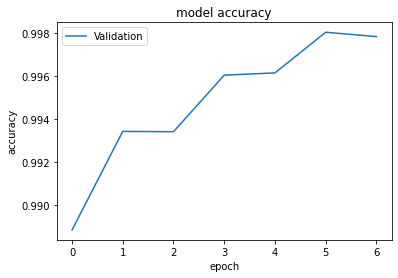

[0, 0, 0, 0, 0, 0, 0]


In [5]:
print('Execution time:', history['elapsed_time'], 'seconds')
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history['scores'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()
print(history['epochs'])